# HOLOGRAFÍA DIGITAL FUERA DE EJE

# Método de Fourier o técnica de filtrado

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt 
from matplotlib.colors import LogNorm
from scipy import cluster, constants, fftpack, integrate

# Creamos las gradillas y presentamos los parámetros fijos

In [2]:
N = 1650; #número máximo de píxeles  recogidos de la imagen en la dirección x
M = 1160; #número máximo de píxeles  recogidos de la imagen en la dirección y
deltax, deltay = (0.001, 0.001); #distancia entre píxeles
X = np.linspace(0,1,num = N+1);
Y = np.linspace(0,1,num = M+1);
x, y = np.meshgrid(X, Y); #creación del sistema N x M
theta = np.pi/4;  #angulo interferencial 1 (rad)
lamb = 632.8 *10**(-8); #longitud de onda (632.8 nm)
z =  N * deltax**(2) / lamb #distancia de propagación hasta el holograma
k = (2*np.pi) /lamb; #vector de propagacion en (rad/m)

# Definimos las funciones que vamos a utilizar

In [3]:
def UnitBox(coordenate1, coordenate2):
    n1 = coordenate1.ndim;
    n2 = coordenate2.ndim;
    Radius= np.sqrt(coordenate1**2 + coordenate2**2);
    Disk = np.zeros_like((Radius));
    limit = 1/2;
    if (n1 == 1 & n2 == 1):
        for ii in range(0,N-1):
            if  ((coordenate1[ii] <= limit) & (coordenate1[ii] >= -limit)):
                Disk[ii] = 1.0;
    elif (n1 == 2 & n2 == 2):
        for ii in range(0,N-1):
            for jj in range(0,N-1):
                if  (Radius[ii][jj] < limit):
                    Disk[ii][jj] = 1.0;
    return Disk

def filter_VanderLught(I_F_): # Filtro de VanderLught
    
    N_2 = int(N/2);
    M_2 = int(M/2);
    Ux = np.arange(-N_2, N_2+1);
    Uy = np.arange(-M_2, M_2+1);
    [ux, uy] = np.meshgrid(Ux, Uy);
    f = 100;
    filtered_signal = (ux > (f - f//2 ))*(ux < (f  + f//2));

    return filtered_signal

# Extraemos la información de la imagen

Dimensiones originales de la imagen:  (1161, 1651, 3)
Número total de dimensiones:  3


Text(0, 0.5, 'píxeles recogidos en la coordenada y')

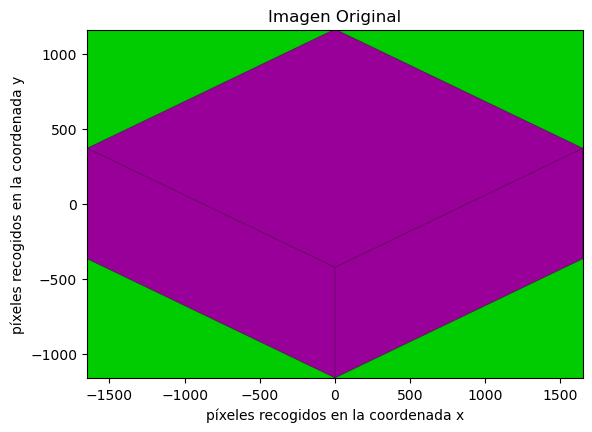

In [4]:
img = cv2.imread('holography_test_image_rgb.jpeg', cv2.IMREAD_UNCHANGED); # equivale a la matriz de variación de amplitud de la onda objeto
img_rgb = np.float64(img); #añadimos precisión
print('Dimensiones originales de la imagen: ',img.shape);
print('Número total de dimensiones: ',img.ndim);
plt.imshow(img, extent=[-N, N, -M, M])
plt.title("Imagen Original")
plt.xlabel("píxeles recogidos en la coordenada x")
plt.ylabel("píxeles recogidos en la coordenada y")

# La transformamos a blanco y negro 

Dimensiones de la imagen en blanco y negro:  (1161, 1651)
Número total de dimensiones de la imagen en blanco y negro:  2


Text(0, 0.5, 'píxeles recogidos en la coordenada y')

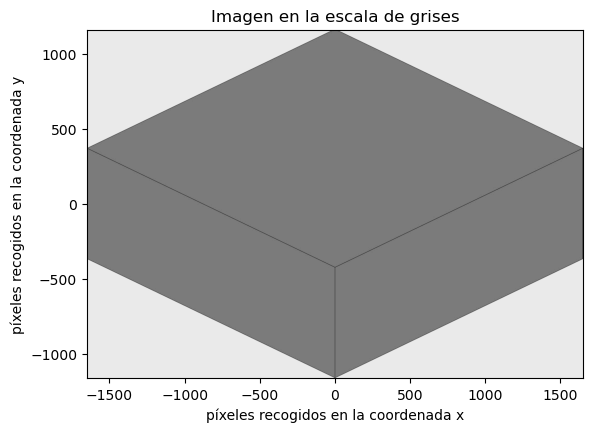

In [5]:
img = cv2.resize(img, (N, M));
img_g = cv2.imread('holography_test_image_rgb.jpeg', cv2.IMREAD_GRAYSCALE); # miminizamos la información de la amplitud 
img_gray = np.float64(img_g); #añadimos precisión
print('Dimensiones de la imagen en blanco y negro: ',img_gray.shape);
print('Número total de dimensiones de la imagen en blanco y negro: ',img_gray.ndim);
A_0= np.fft.fftshift(np.fft.fft2(img_gray)); #amplitud distribución de amplitud del haz objeto
plt.imshow(img_g, cmap = 'gray', extent=[-N, N, -M, M])
plt.title("Imagen en la escala de grises")
plt.xlabel("píxeles recogidos en la coordenada x")
plt.ylabel("píxeles recogidos en la coordenada y")

# Intensidad de la interferencia en el dominio espacial

In [6]:
UO = img_gray * np.exp(1j*np.pi/2*UnitBox(X,X))*np.exp(1j*k*x*np.sin(theta)); #haz objeto
UO= UO/ np.max(UO); #normalizamos
UO_abs = np.abs(UO)**2; #devuelve valores absolutos de la matriz UO
UO_abs = np.where(UO_abs > 0.0000000001, UO_abs, -10); #transformamos UO a escala logarítmica
UO_log = np.log10(UO_abs, out=UO_abs, where=UO_abs > 0);      
UR = np.exp(1j*k*x); #haz de referencia
UR= UR/ np.max(UR); #normalizamos

In [7]:
I = np.abs(UO + UR)**2; #intensidad resultante de la interferencia entre UO y UR

# Intensidad de la interferencia en el dominio frecuencial

In [8]:
I_F= np.fft.fftshift(np.fft.fft2(np.fft.fftshift(I))) #distribución de amplitud del haz objeto inicial
I_F_abs = np.abs(I_F); # calculamos el valor absoluto de la intensidad en el plano de Fourier
I_F_log = 20 * np.log10(I_F_abs); #lo convertimos a la escala logratimica

# Aplicamos el filtro sobre la intensidad espectral

In [9]:
fil= filter_VanderLught(I_F)
G = I_F *fil; # G es la distribución de amplitud resultante tras aplicar el filtro
G_abs = np.abs(G) #calculamos los valores absolutos de la matriz G
G_abs_ = np.where(G_abs > 0.0000000001, G_abs, -10);
G_log = np.log10(G_abs, out=G_abs, where=G_abs > 0); #transformamos G a escala logarítmica

# Reconstrucción de la onda objeto

In [10]:
G = np.fft.ifftshift(np.fft.ifft2(np.fft.ifftshift(G )))
CF = UR * G;
CF_abs = np.abs(CF) #devuelve valores absolutos de la matriz CF 
CF_abs_ = np.where(CF_abs > 0.0000000001, CF_abs, -10);
CF_log = np.log10(CF_abs, out=CF_abs, where=CF_abs > 0); #transformamos CF a escala logarítmica para tener información más precisa

# Representación de los resultados

Text(0, 0.5, 'Coordenada normalizada y')

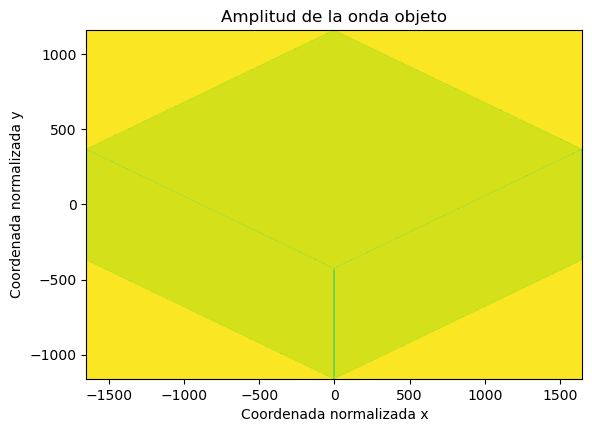

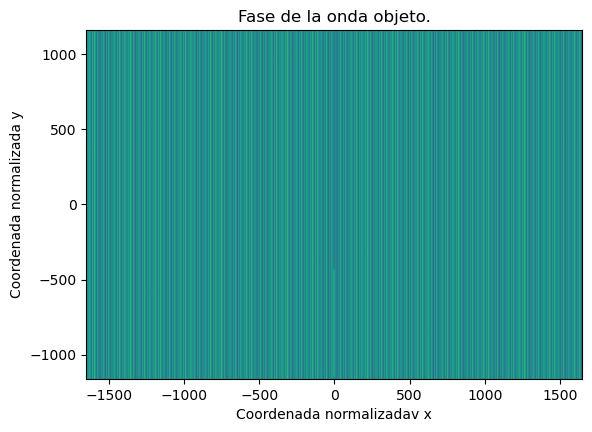

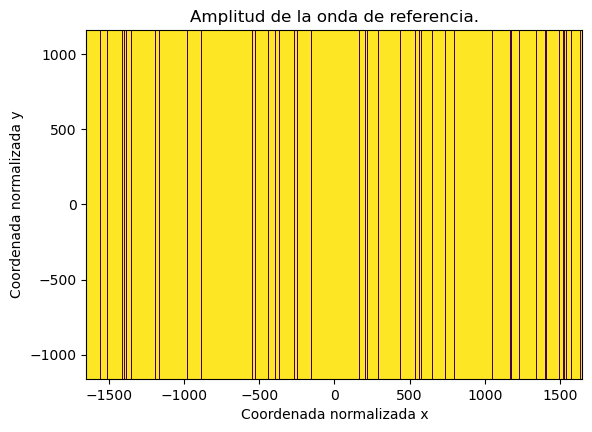

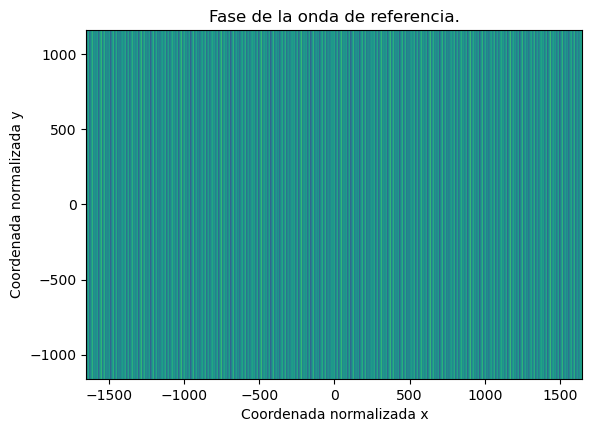

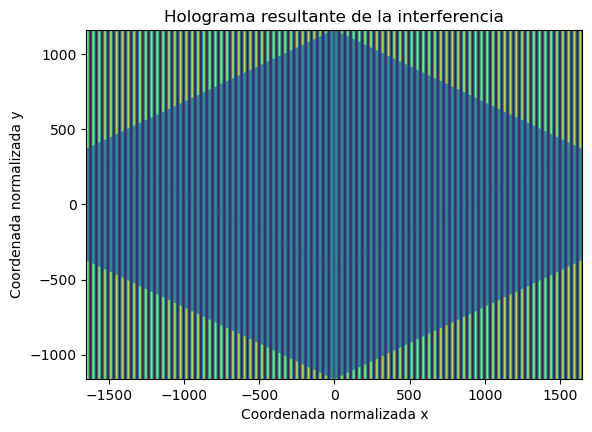

In [11]:
plt.figure()
plt.subplot()
plt.imshow(UO_log, extent=[-N, N, -M, M])
plt.title('Amplitud de la onda objeto')
plt.xlabel("Coordenada normalizada x")
plt.ylabel("Coordenada normalizada y")

plt.figure()
plt.subplot()
plt.imshow(np.angle(UO), extent=[-N, N, -M, M])
plt.title('Fase de la onda objeto.')
plt.xlabel("Coordenada normalizadav x")
plt.ylabel("Coordenada normalizada y")

plt.figure()
plt.subplot()
plt.imshow(np.abs(UR), extent=[-N, N, -M, M])
plt.title('Amplitud de la onda de referencia.')
plt.xlabel("Coordenada normalizada x")
plt.ylabel("Coordenada normalizada y")

plt.figure()
plt.subplot()
plt.imshow(np.angle(UR), extent=[-N, N, -M, M])
plt.title('Fase de la onda de referencia.')
plt.xlabel("Coordenada normalizada x")
plt.ylabel("Coordenada normalizada y")

plt.figure()
plt.subplot()
plt.imshow(I, extent=[-N, N, -M, M])
plt.title('Holograma resultante de la interferencia')
plt.xlabel("Coordenada normalizada x")
plt.ylabel("Coordenada normalizada y")

Text(0, 0.5, 'Coordenada normalizada y')

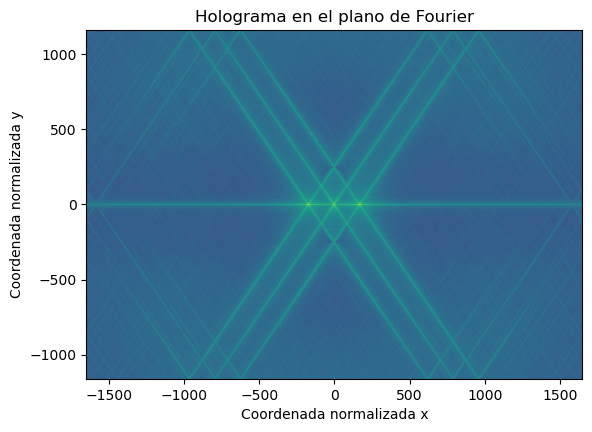

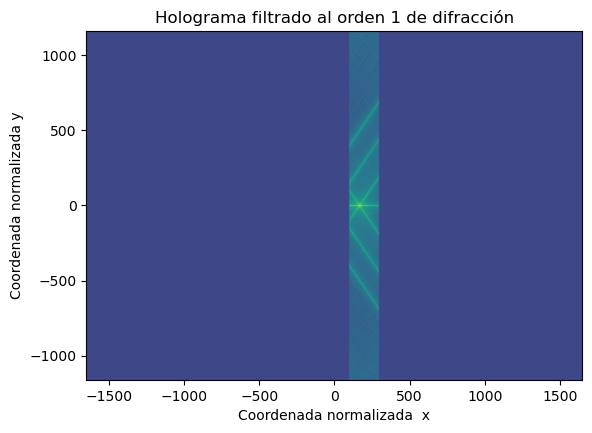

In [12]:
plt.figure()
plt.imshow(I_F_log, extent=[-N, N, -M, M])
plt.title("Holograma en el plano de Fourier")
plt.xlabel("Coordenada normalizada x")
plt.ylabel("Coordenada normalizada y")

plt.figure()
plt.imshow(G_log, extent=[- N, N, -M, M])
plt.title("Holograma filtrado al orden 1 de difracción")
plt.xlabel("Coordenada normalizada  x")
plt.ylabel("Coordenada normalizada y")

Text(0, 0.5, 'Coordenada normalizada y')

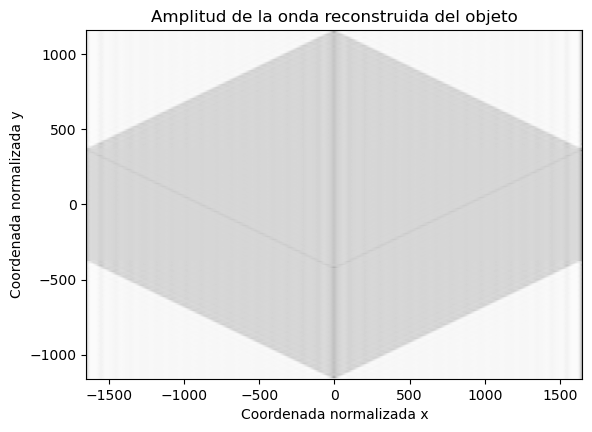

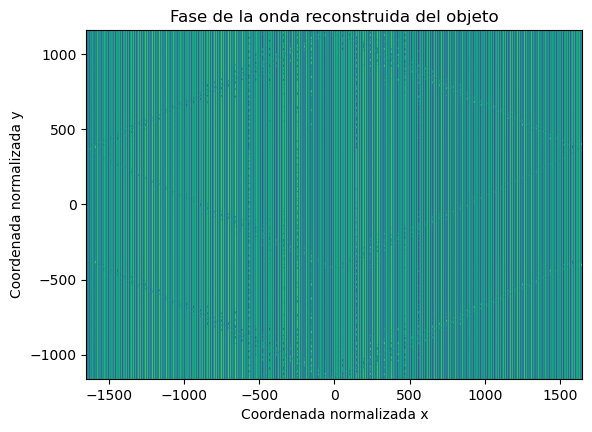

In [13]:
plt.figure()
plt.subplot()
plt.imshow(CF_log, cmap = 'gray', extent=[-N, N, -M, M])
plt.title("Amplitud de la onda reconstruida del objeto")
plt.xlabel("Coordenada normalizada x")
plt.ylabel("Coordenada normalizada y")
        
plt.figure()
plt.subplot()
plt.imshow(np.angle(CF), extent=[-N, N, -M, M])
plt.title("Fase de la onda reconstruida del objeto")
plt.xlabel("Coordenada normalizada x")
plt.ylabel("Coordenada normalizada y")

# Tal y como se esperaba, el método de Fourier pierde información en la reconstrucción.